In [1]:
import pandas as pd
from datasets import load_dataset, concatenate_datasets
from matplotlib import pyplot as plt

Reading the raw dataset.

In [2]:
ds = load_dataset(
    "Jacobvs/PoliticalTweets",
    revision="1ddaa14beed79edda621fdd72ad22fd654d760b3"
)
df = concatenate_datasets(ds.values()).to_pandas()
df = df.set_index("index").rename_axis(None)
df

README.md:   0%|          | 0.00/21.0 [00:00<?, ?B/s]

formatted_data.parquet:   0%|          | 0.00/26.6M [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

,date,id,username,text,party,labels
0,2021-10-13 19:47:44,1448374915636383745,SenatorHassan,Happy th birthday to the @USNavy! The strength...,Democrat,1
1,2021-06-30 14:53:13,1410250073003462656,SenatorMenendez,The greatest generation's investment in infras...,Democrat,1
2,2021-08-08 01:11:29,1424176405881966599,SenBillCassidy,"Thanks to @SenTedCruz and @SenatorWarnock, th...",Republican,0
3,2021-04-14 14:02:49,1382333523567185921,SenBlumenthal,/ To get lasting change we cant just lock up t...,Democrat,1
4,2021-12-11 16:06:38,1469700160934621188,SenatorBraun,Today were celebrating years of the Hoosier st...,Republican,0
...,...,...,...,...,...,...
191475,2022-05-13 15:00:51,1525128949583462402,RepWalberg,Religious liberty is foundational to America. ...,Republican,0
191476,2022-05-12 20:36:47,1524851099211120640,RepWalberg,"During #NationalPoliceWeek, I want to give a h...",Republican,0
191477,2022-05-12 17:47:11,1524808421488336896,RepWalberg,The same week that gas prices hit a record hig...,Republican,0
191478,2022-05-12 15:26:15,1524772953501712384,RepWalberg,Amid another mounting crisis—a nationwide shor...,Republican,0


Dropping useless columns.

In [3]:
df = df.drop(columns=["id", "username", "labels"])

Renaming columns.

In [4]:
df = df.rename(columns={"text": "body", "party": "leaning"})

Categorizing the leaning column.

In [5]:
df["leaning"].unique()

array(['Democrat', 'Republican'], dtype=object)

In [6]:
df["leaning"] = df["leaning"].replace({"Democrat": "left", "Republican": "right"})
df["leaning"] = df["leaning"].astype("category")

Dropping rows with missing data.

In [7]:
df = df.dropna()

Printing duplicates.

In [8]:
df[df["body"].duplicated(keep=False)]

,date,body,leaning
250,2021-06-04 22:40:22,"As India fights its #COVID19 crisis, it's impo...",right
907,2021-05-21 18:36:59,Find a vaccine location near you: Search https...,left
1664,2021-06-10 20:55:41,S.1 makes election fraud easier to commit and ...,right
2736,2021-12-01 21:33:25,https://t.co/nIOlNKmqik,left
2800,2021-07-06 13:16:34,There still is a crisis at the border.,right
...,...,...,...
188646,2017-09-06 13:53:23,The Huntsville/Madison County Emergency Manage...,right
189854,2022-11-01 19:11:54,Border security is national security.,right
189870,2022-10-21 13:02:00,Energy security is national security.,right
189881,2022-10-14 14:30:01,Energy security is national security.,right


Dropping the duplicates.

In [9]:
df = df.drop_duplicates(subset="body")

Inspecting body length.

In [10]:
df["body_length"] = df["body"].str.len()
df["body_word_count"] = df["body"].str.split().str.len()
df = df.sort_values(by="body_length")
df.head(100)

,date,body,leaning,body_length,body_word_count
29594,2021-12-05 23:10:13,,left,0,0
94331,2021-07-27 19:50:25,vs,left,2,1
158362,2022-11-29 21:03:26,🇺🇸,right,2,1
51544,2021-11-06 22:57:41,Set,right,3,1
153201,2022-09-01 20:29:03,utah,right,4,1
...,...,...,...,...,...
77476,2021-11-03 03:04:16,God bless America.,right,18,3
185896,2022-11-29 14:31:17,Secure the border.,right,18,3
164640,2022-09-28 18:18:05,Finish. The. Wall.,right,18,3
150470,2023-01-01 18:35:47,Happy New Year!!🎆🎊,right,18,3


After inspection, articles with bodies shorter than 2 words seem to contain no political value. Removing them.

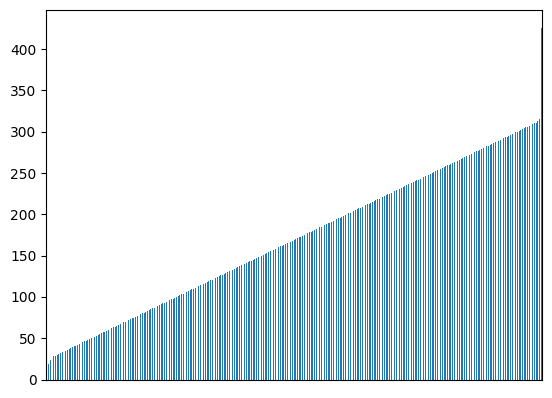

In [11]:
body_word_count_lower_bound = 2
df = df[df["body_word_count"] >= body_word_count_lower_bound]
# Ensuring to include the last (longest) item.
downsampled = pd.concat([df["body_length"].iloc[::100], df["body_length"].tail(1)]).drop_duplicates()
downsampled.plot.bar().xaxis.set_ticks([]);

In [12]:
df["body_length"].mean()

np.float64(175.78371146015124)

The leaning distribution.

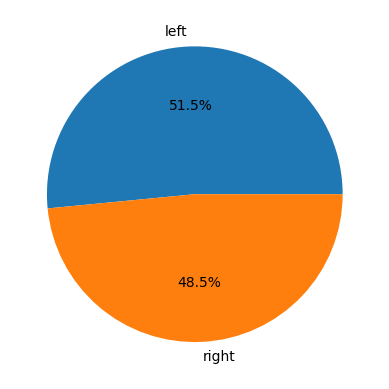

In [13]:
df.groupby("leaning", observed=True).size().plot.pie(autopct="%1.1f%%");

The distribution of body length sums per leaning.

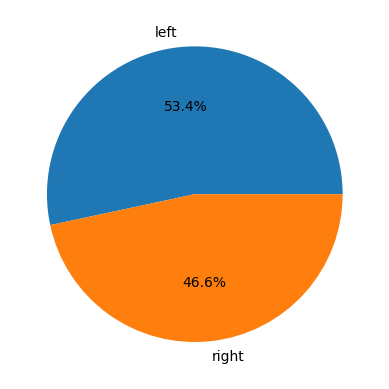

In [14]:
df.groupby("leaning", observed=True)["body_length"].sum().plot.pie(autopct="%1.1f%%", ylabel="");

Body length distribution by leaning.

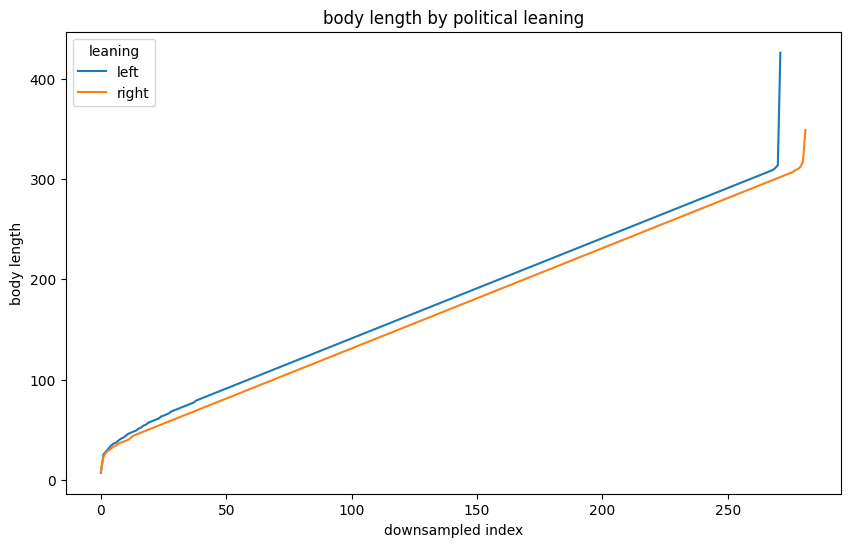

In [15]:
plt.figure(figsize=(10, 6))

for leaning in df["leaning"].unique():
    df_leaning = df[df["leaning"] == leaning]
    downsampled = pd.concat(
        # Ensuring to include the last (longest) item.
        [df_leaning["body_length"].iloc[::100], df_leaning["body_length"].tail(1)]
    ).drop_duplicates().reset_index(drop=True)
    plt.plot(downsampled, label=leaning)

plt.xlabel("downsampled index")
plt.ylabel("body length")
plt.title("body length by political leaning")
plt.legend(title="leaning")
plt.show()

In [16]:
df.to_parquet("../preprocessed/political_tweets.parquet")